In [1]:
import keras

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
keras.__version__

'2.1.1'

Посмотрим как различные сверточные слои преобразуют исходную картинку.

In [3]:
%pylab inline
from scipy import ndimage

Populating the interactive namespace from numpy and matplotlib


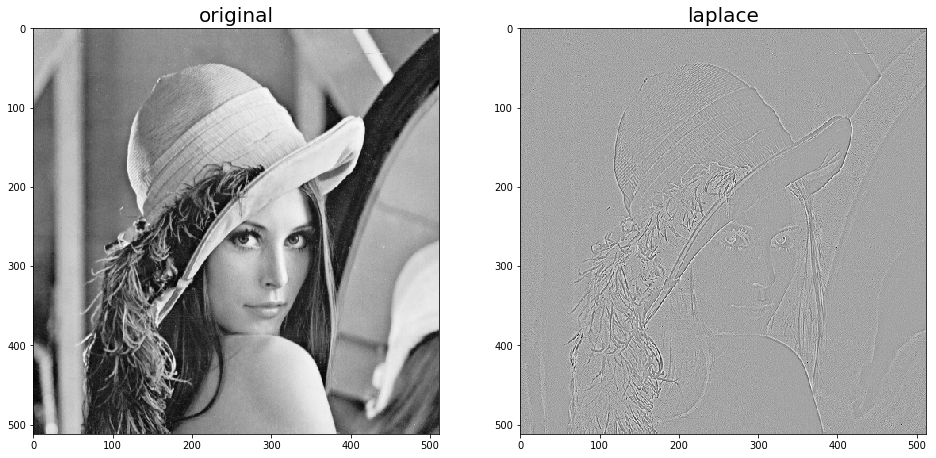

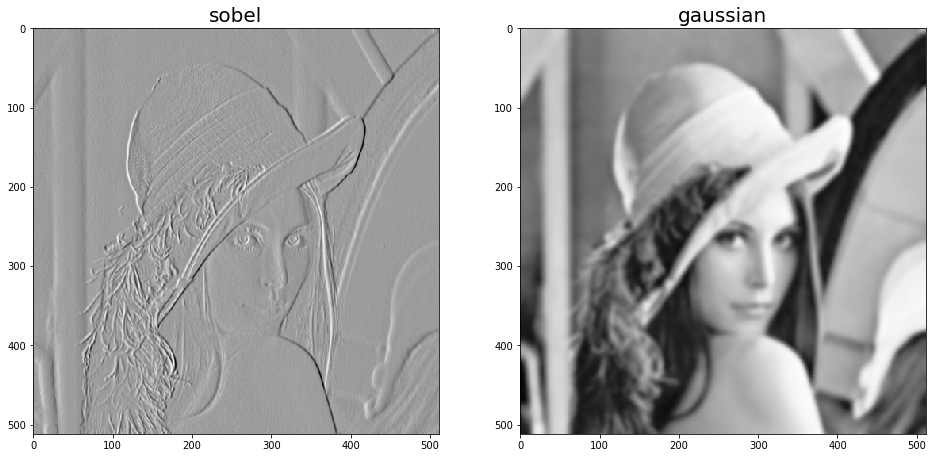

In [4]:
gad = plt.imread('Lenna.png')
gad = np.mean(gad,axis=2)

figsize(16,8)
plt.subplot(121)
plt.imshow(gad, cmap='Greys_r')
plt.title('original', fontsize=20)
plt.subplot(122)
plt.imshow(ndimage.laplace(gad), cmap='Greys_r')
plt.title('laplace', fontsize=20)
plt.show()
plt.subplot(121)
plt.imshow(ndimage.sobel(gad), cmap='Greys_r')
plt.title('sobel', fontsize=20)
plt.subplot(122)
plt.imshow(ndimage.gaussian_filter(gad, sigma=3), cmap='Greys_r')
_ = plt.title('gaussian', fontsize=20)

In [5]:
import os
import copy
import numpy as np
import skimage.transform

Скачаем котиков и собачек: https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1

In [6]:
filenames = os.listdir('train')
filenames = map(lambda name: os.path.join('train', name), filenames)
cat_files = list(filter(lambda name: 'cat' in name, copy.copy(filenames)))

filenames = os.listdir('train')
filenames = map(lambda name: os.path.join('train', name), filenames)
dog_files = list(filter(lambda name: 'dog' in name, copy.copy(filenames)))

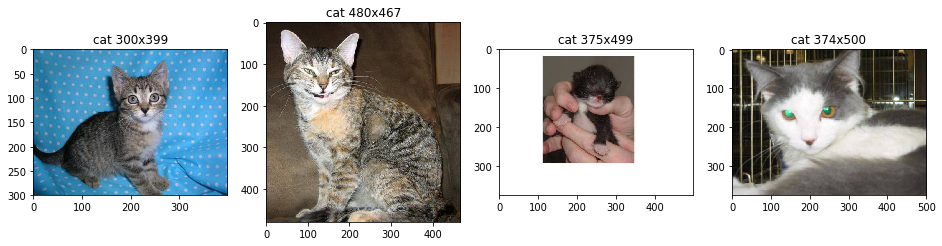

In [7]:
figsize(16,8)

for i in range(4):
    plt.subplot(1,4,i+1)
    im = plt.imread(cat_files[i])
    plt.title('cat %dx%d' % (im.shape[0], im.shape[1]))
    plt.imshow(im)

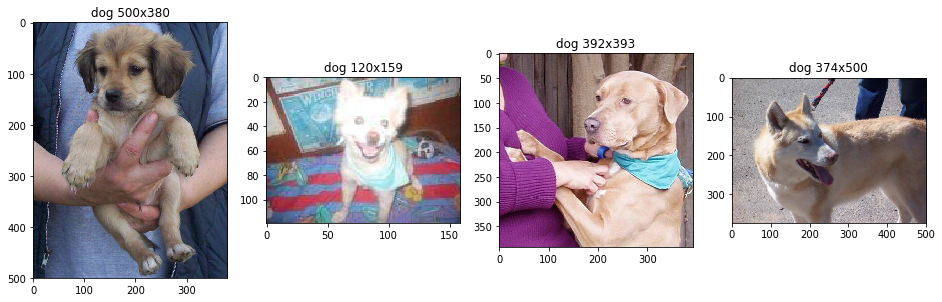

In [8]:
figsize(16,8)

for i in range(4):
    plt.subplot(1,4,i+1)
    im = plt.imread(dog_files[i])
    plt.title('dog %dx%d' % (im.shape[0], im.shape[1]))
    plt.imshow(im)

In [9]:
def process_image(im):
    result_w = 224
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (result_w, w*result_w//h))
    else:
        im = skimage.transform.resize(im, (h*result_w//w, result_w))

    # Central crop
    h, w, _ = im.shape
    im = im[h//2-result_w//2:h//2+result_w//2, w//2-result_w//2:w//2+result_w//2, :]
    return im

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


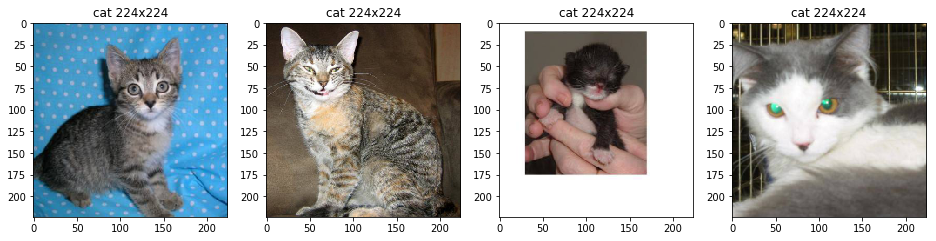

In [10]:
figsize(16,8)

for i in range(4):
    plt.subplot(1,4,i+1)
    im = process_image(plt.imread(cat_files[i]))
    plt.title('cat %dx%d' % (im.shape[0], im.shape[1]))
    plt.imshow(im)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


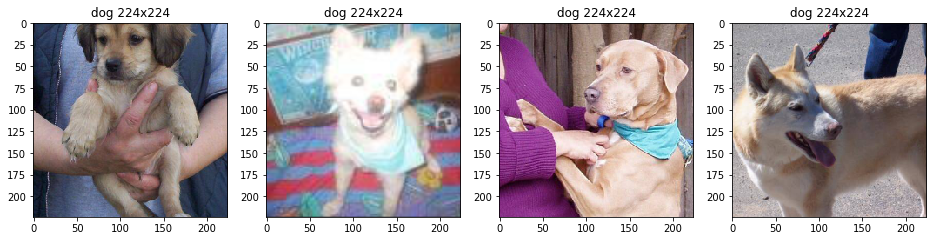

In [11]:
figsize(16,8)

for i in range(4):
    plt.subplot(1,4,i+1)
    im = process_image(plt.imread(dog_files[i]))
    plt.title('dog %dx%d' % (im.shape[0], im.shape[1]))
    plt.imshow(im)

Теперь сконстрируем нейросеть с помощью пакета Keras - дружелюбной обертки вокруг tensorflow.

Создаем модель.

In [12]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Flatten

model = Sequential()

In [13]:
from keras.layers import Dense

model.add(ZeroPadding2D((1,1),input_shape=(224, 224, 3)))
model.add(Convolution2D(filters=10, kernel_size=3, activation='relu', data_format='channels_last'))
model.add(ZeroPadding2D((1,1)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))

# здесь количество unit'ов последенего слоя должно совпадать с количеством классов (либо в случае бинарной классификации быть равным 1).
model.add(Dense(units=1, activation='softmax'))

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
dogs = np.zeros([2000, 224, 224, 3])
cats = np.zeros([2000, 224, 224, 3])
i = 0
for i in range(2000):
    dogs[i,:,:,:] = process_image(plt.imread(dog_files[i]))
    cats[i,:,:,:] = process_image(plt.imread(cat_files[i]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


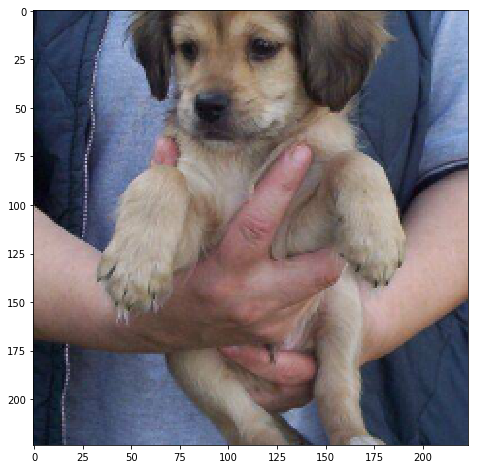

In [16]:
plt.imshow(dogs[0])

In [17]:
X_train = np.concatenate([dogs, cats], axis = 0)
y_train = np.zeros(len(X_train))
y_train[:2000] = 1

In [18]:
model.fit(x=X_train, y=y_train)

Epoch 1/1
4000/4000 [==============================] - 251s 63ms/step - loss: 7.9712 - acc: 0.5000


Очень плохо :(. Давайте теперь возьмем глубокую предобученную сеть VGG16 и посмотрим, что получится там.

In [19]:
from keras.applications import vgg16

model = vgg16.VGG16(include_top=True)

In [20]:
vgg16.decode_predictions(model.predict(np.array([X_train[2001] * 255])))

[[('n02124075', 'Egyptian_cat', 0.63530046),
  ('n02123045', 'tabby', 0.27908137),
  ('n02123159', 'tiger_cat', 0.080892965),
  ('n02127052', 'lynx', 0.0014989723),
  ('n04589890', 'window_screen', 0.00065206684)]]

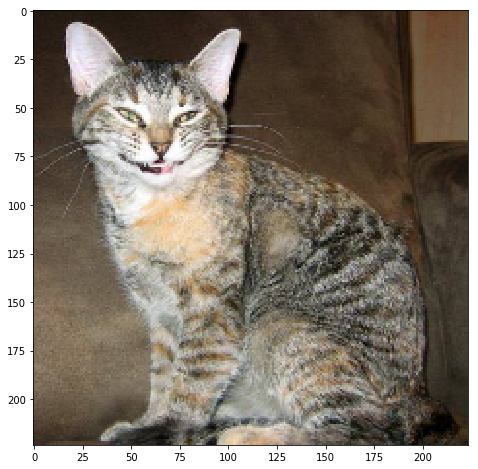

In [21]:
plt.imshow(X_train[2001])

In [22]:
vgg16.decode_predictions(model.predict(np.array([X_train[26] * 255])))

[[('n02099712', 'Labrador_retriever', 0.21316017),
  ('n02091134', 'whippet', 0.16437782),
  ('n02093428', 'American_Staffordshire_terrier', 0.12928127),
  ('n02105412', 'kelpie', 0.12504037),
  ('n02111500', 'Great_Pyrenees', 0.040994175)]]

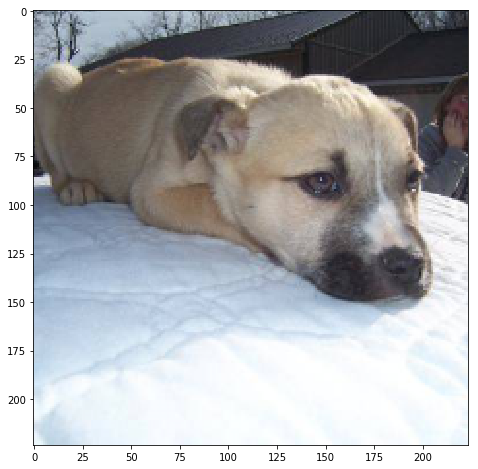

In [23]:
plt.imshow(X_train[26])

А может логит регрессии будет достаточно?

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [27]:
X_tr, X_test, y_tr, y_test = train_test_split(X_train, y_train, test_size=0.4, shuffle=True)

In [28]:
rf = LogisticRegression()

In [40]:
rf.fit(X_tr[:100].reshape(100, -1), y_tr[:100])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [41]:
from sklearn.metrics import roc_auc_score

In [42]:
roc_auc_score(y_test[:200], rf.predict_proba(X_test[:200].reshape(200, -1))[:, 1])

0.51177536231884058